<a href="https://colab.research.google.com/github/PrinceDevelop/MediSharp-AI/blob/main/high_resolution_image_generator_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# requirements.txt

In [21]:
# ✅ Create a proper requirements.txt file for Render / Deployment
with open("requirements.txt", "w") as f:
    f.write("""tensorflow==2.17.0
numpy
pandas
matplotlib
Pillow
gradio
kagglehub
""")

# ✅ Verify file content
!cat requirements.txt



tensorflow==2.17.0
numpy
pandas
matplotlib
Pillow
gradio
kagglehub



# Medical Image Enhancement GAN (CPU Optimized, RGB)
# Dataset: Kvasir-SEG via KaggleHub


In [2]:
#!pip install -U ml_dtypes jax jaxlib tensorflow

In [3]:
import os, random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.8.0, so it will not be used.
  warnings.warn(



# 1. Download Dataset


In [4]:
path = kagglehub.dataset_download("debeshjha1/kvasirseg")
print("Dataset downloaded at:", path)

base_dir = os.path.join(path, "Kvasir-SEG")
image_dir = base_dir

IMG_SIZE = 256
BATCH_SIZE = 4


Dataset downloaded at: /kaggle/input/kvasirseg



# 2. ImageDataGenerator for Loading RGB Images


In [5]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    directory=image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='rgb',      # ensure RGB
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    directory=image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='rgb',      # ensure RGB
    subset='validation',
    shuffle=False
)

Found 2400 images belonging to 1 classes.
Found 600 images belonging to 1 classes.



# 3. Low-Res / High-Res Pair Generator (RGB preserved)


In [6]:
def pair_generator(gen):
    for batch in gen:
        high_res = tf.convert_to_tensor(batch, dtype=tf.float32)
        # Low-res -> upscaled back to original size
        low_res = tf.image.resize(high_res, [IMG_SIZE//2, IMG_SIZE//2])
        low_res = tf.image.resize(low_res, [IMG_SIZE, IMG_SIZE])
        yield low_res, high_res

train_dataset = tf.data.Dataset.from_generator(
    lambda: pair_generator(train_gen),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: pair_generator(val_gen),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

print("Dataset ready.")

Dataset ready.



# 4. Generator (U-Net)


In [7]:
def build_generator():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    e1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs); e1 = layers.LeakyReLU(0.2)(e1)
    e2 = layers.Conv2D(128, 4, strides=2, padding='same')(e1); e2 = layers.BatchNormalization()(e2); e2 = layers.LeakyReLU(0.2)(e2)
    e3 = layers.Conv2D(256, 4, strides=2, padding='same')(e2); e3 = layers.BatchNormalization()(e3); e3 = layers.LeakyReLU(0.2)(e3)
    b  = layers.Conv2D(512, 4, strides=2, padding='same')(e3); b  = layers.ReLU()(b)
    d1 = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(b); d1 = layers.BatchNormalization()(d1); d1 = layers.ReLU()(d1); d1 = layers.Concatenate()([d1, e3])
    d2 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(d1); d2 = layers.BatchNormalization()(d2); d2 = layers.ReLU()(d2); d2 = layers.Concatenate()([d2, e2])
    d3 = layers.Conv2DTranspose(64,  4, strides=2, padding='same')(d2); d3 = layers.BatchNormalization()(d3); d3 = layers.ReLU()(d3); d3 = layers.Concatenate()([d3, e1])
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(d3)
    return Model(inputs, outputs, name="Generator")



# 5. Discriminator (PatchGAN)


In [8]:
def build_discriminator():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    tar = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Concatenate()([inp, tar])
    x = layers.Conv2D(64, 4, strides=2, padding='same')(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128,4,strides=2,padding='same')(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256,4,strides=2,padding='same')(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(1,4,padding='same')(x)
    return Model([inp, tar], x, name="Discriminator")


# 6. Losses & Optimizers


In [9]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(disc_gen, gen_out, target):
    adv = bce(tf.ones_like(disc_gen), disc_gen)
    l1  = tf.reduce_mean(tf.abs(target - gen_out))
    return adv + 100*l1

def disc_loss(disc_real, disc_gen):
    real = bce(tf.ones_like(disc_real), disc_real)
    fake = bce(tf.zeros_like(disc_gen), disc_gen)
    return real + fake

generator     = build_generator()
discriminator = build_discriminator()
g_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)



# 7. Train Step


In [10]:
@tf.function
def train_step(inp, tar):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        gen_out = generator(inp, training=True)
        disc_real = discriminator([inp, tar], training=True)
        disc_gen  = discriminator([inp, gen_out], training=True)
        g_loss = gen_loss(disc_gen, gen_out, tar)
        d_loss = disc_loss(disc_real, disc_gen)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return g_loss, d_loss


# 8. Training Loop (Finite Steps)


In [11]:
steps_per_epoch = train_gen.n // BATCH_SIZE
EPOCHS = 10  # increase for real training

for ep in range(EPOCHS):
    print(f"\nEpoch {ep+1}/{EPOCHS}")
    for i, (inp, tar) in enumerate(train_dataset.take(steps_per_epoch)):
        g_loss, d_loss = train_step(inp, tar)
        if i % 20 == 0:
            print(f"Step {i}: G={g_loss:.4f} D={d_loss:.4f}")
print("Training Complete.")


Epoch 1/10
Step 0: G=38.0813 D=1.7701
Step 20: G=25.1754 D=0.7741
Step 40: G=18.6581 D=0.6655
Step 60: G=10.6339 D=0.6868
Step 80: G=8.9405 D=0.8933
Step 100: G=6.7026 D=0.9620
Step 120: G=6.0630 D=1.3176
Step 140: G=6.3176 D=0.7945
Step 160: G=7.3869 D=0.9136
Step 180: G=8.9096 D=0.3829
Step 200: G=5.0363 D=1.0258
Step 220: G=5.1216 D=0.8886
Step 240: G=3.6389 D=1.0757
Step 260: G=7.1341 D=0.4443
Step 280: G=7.1332 D=0.7268
Step 300: G=5.0717 D=0.8491
Step 320: G=4.6094 D=1.1113
Step 340: G=3.5233 D=1.2568
Step 360: G=5.6434 D=0.3680
Step 380: G=3.8215 D=0.6776
Step 400: G=5.0473 D=0.6087
Step 420: G=5.0556 D=0.3718
Step 440: G=4.0785 D=0.7000
Step 460: G=4.0909 D=0.7490
Step 480: G=5.4017 D=0.2419
Step 500: G=6.8053 D=0.6752
Step 520: G=3.5798 D=0.8166
Step 540: G=4.4295 D=0.8075
Step 560: G=4.3268 D=0.6295
Step 580: G=5.9500 D=0.1222

Epoch 2/10
Step 0: G=3.0922 D=0.8614
Step 20: G=2.7738 D=1.0973
Step 40: G=5.6585 D=0.1244
Step 60: G=5.4932 D=0.4168
Step 80: G=3.1995 D=0.5622
Step


# 9. PSNR & SSIM Evaluation


In [12]:
def evaluate_quality(true, pred):
    psnr = tf.image.psnr(true, pred, max_val=1.0)
    ssim = tf.image.ssim(true, pred, max_val=1.0)
    return float(tf.reduce_mean(psnr)), float(tf.reduce_mean(ssim))


# 10. Test & Visualize Random Image


In [13]:
def test_random_image():
    i = random.randint(0, train_gen.n-1)
    batch_idx = i // BATCH_SIZE
    idx_in_batch = i % BATCH_SIZE
    batch = train_gen[batch_idx]

    # Original RGB image
    high_res = tf.convert_to_tensor(batch[idx_in_batch], dtype=tf.float32)

    # Low-res input
    low_res = tf.image.resize(high_res, [IMG_SIZE//2, IMG_SIZE//2])
    low_res = tf.image.resize(low_res, [IMG_SIZE, IMG_SIZE])

    # Enhanced output
    enhanced = generator(tf.expand_dims(low_res, 0), training=False)[0]
    enhanced_img = tf.clip_by_value(enhanced, 0.0, 1.0)

    # Convert tensors to NumPy
    high_res_np = high_res.numpy()
    low_res_np = low_res.numpy()
    enhanced_np = enhanced_img.numpy()

    psnr, ssim = evaluate_quality(high_res, enhanced_img)

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Original High-Res")
    plt.imshow(high_res_np, cmap=None)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Low-Res Input")
    plt.imshow(low_res_np, cmap=None)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title(f"Enhanced Output\nPSNR={psnr:.2f}, SSIM={ssim:.3f}")
    plt.imshow(enhanced_np, cmap=None)
    plt.axis('off')

    plt.show()

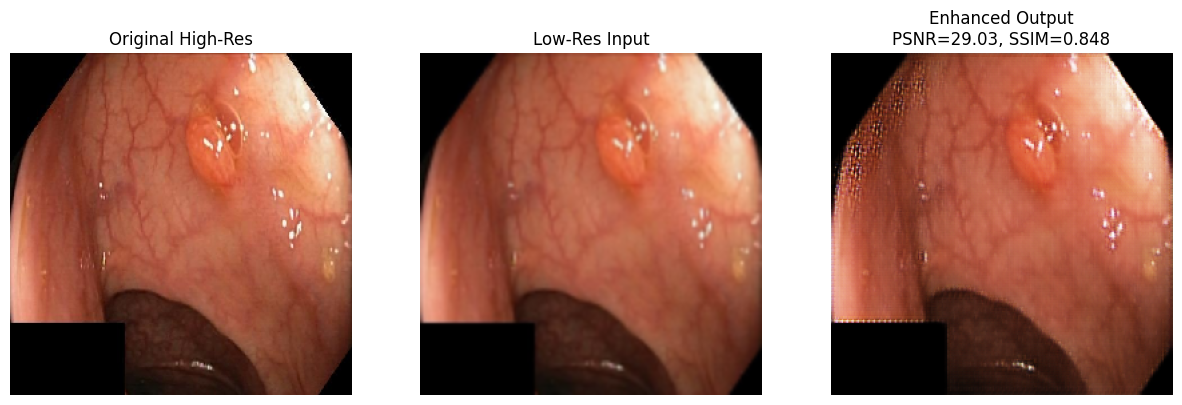

In [14]:
test_random_image()


# 11. Batch Enhancement + Metrics Logging (RGB-safe)


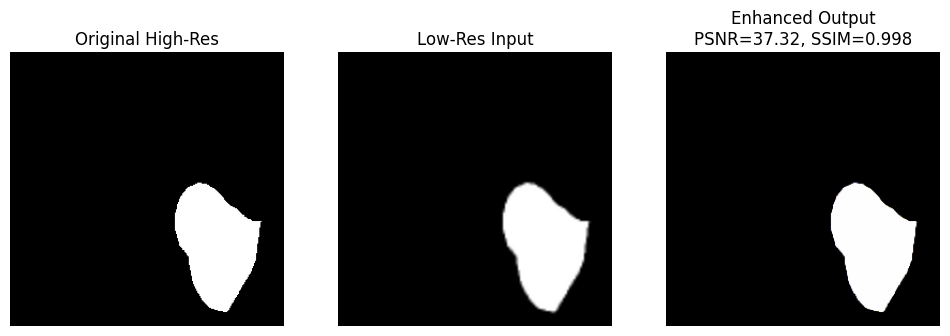

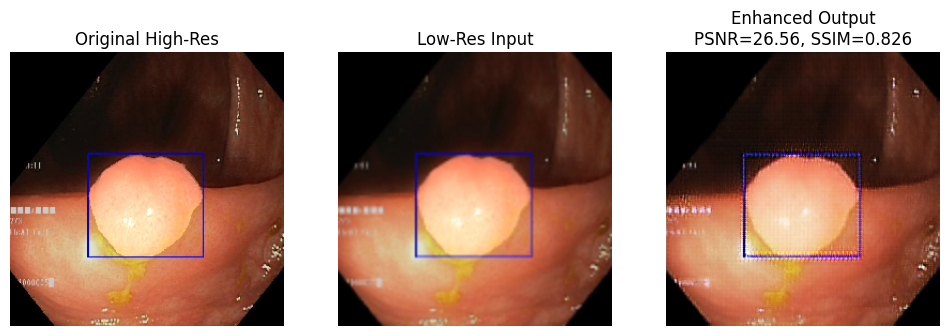

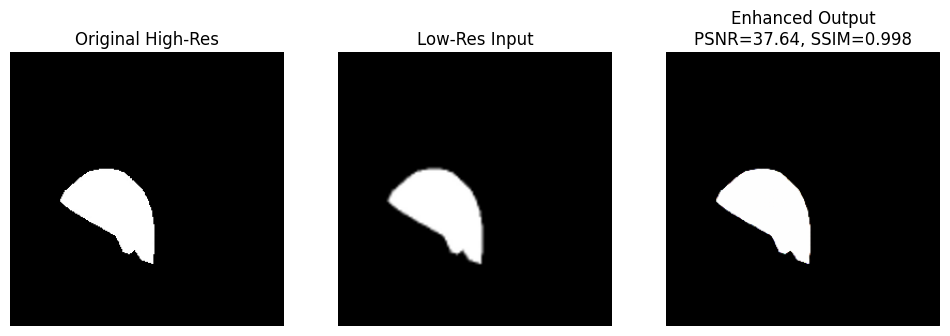

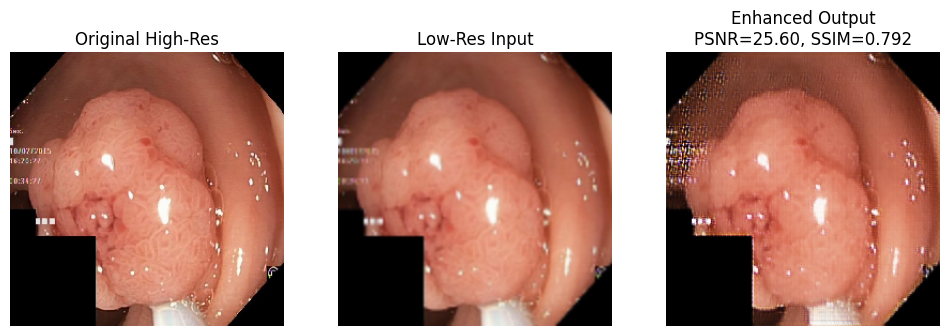

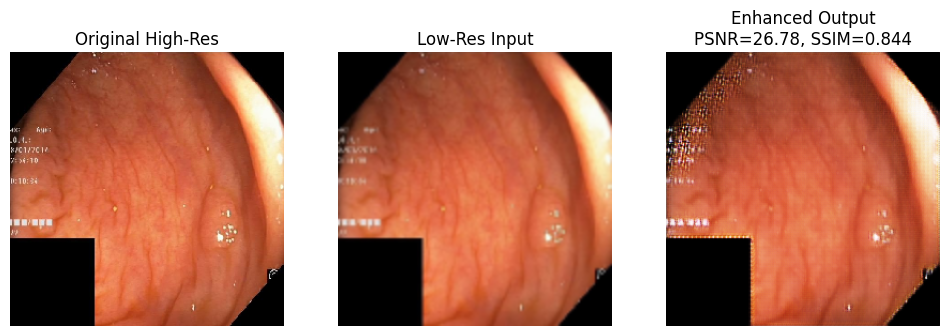

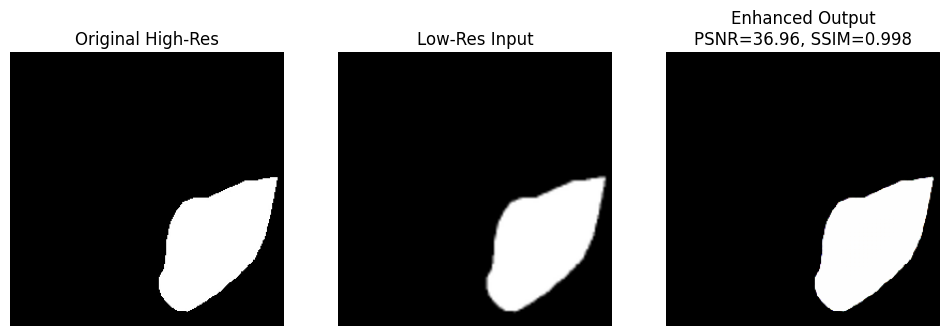

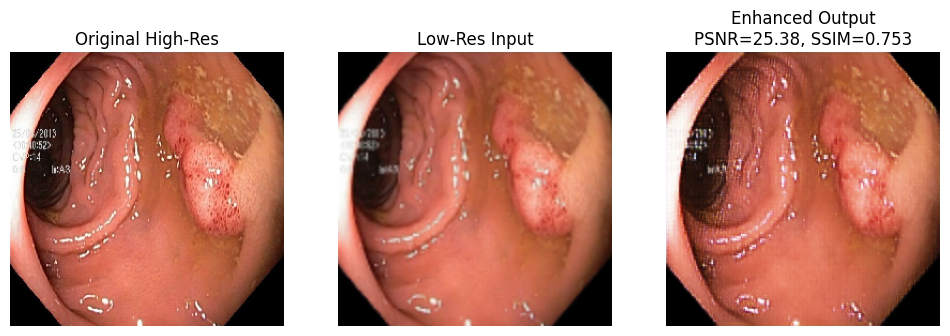

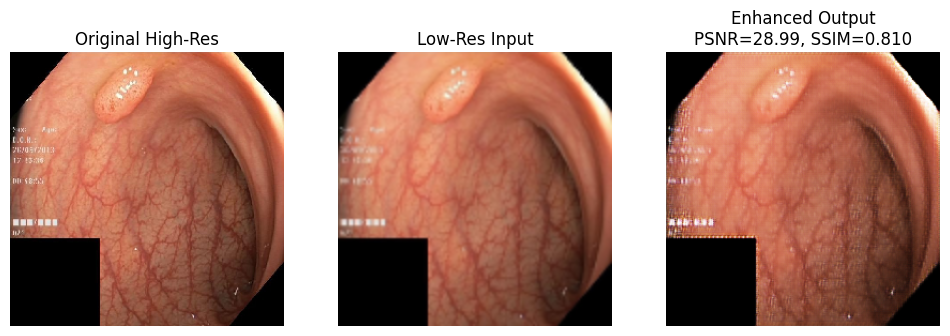

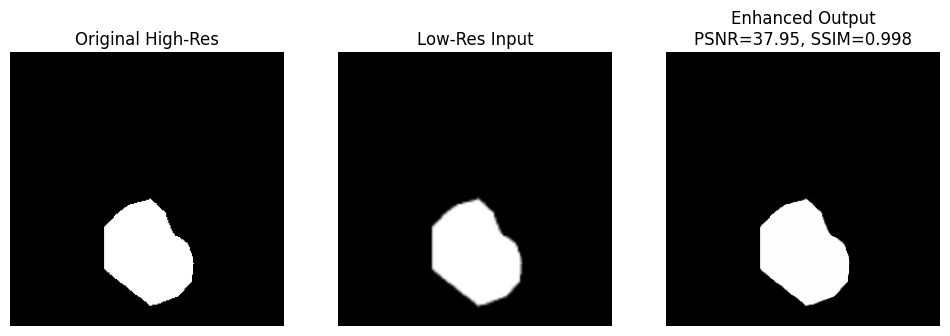

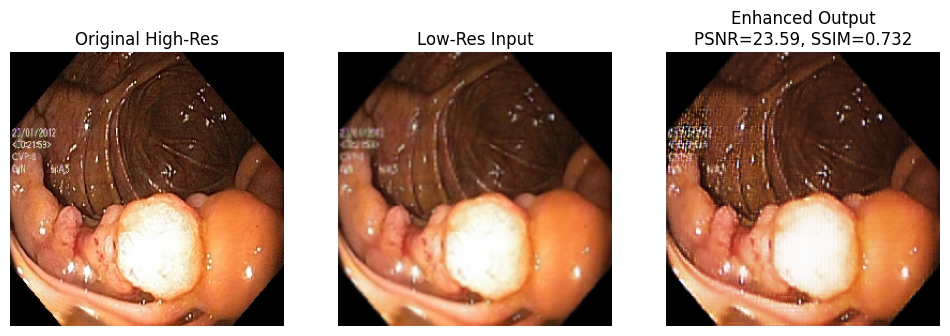

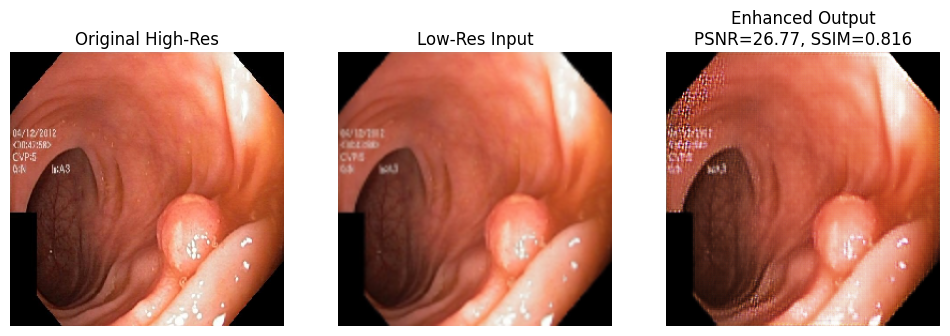

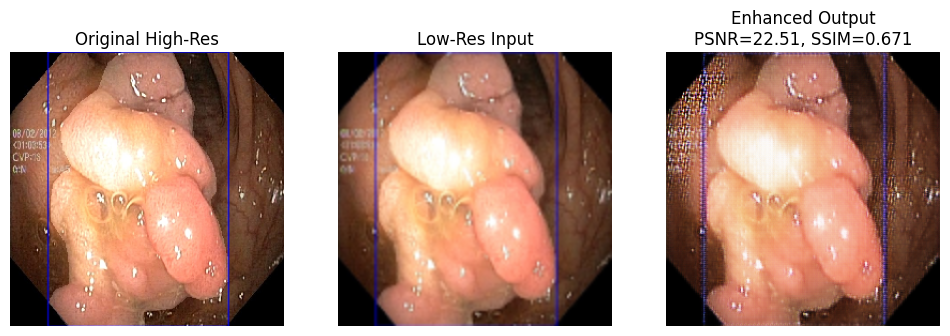

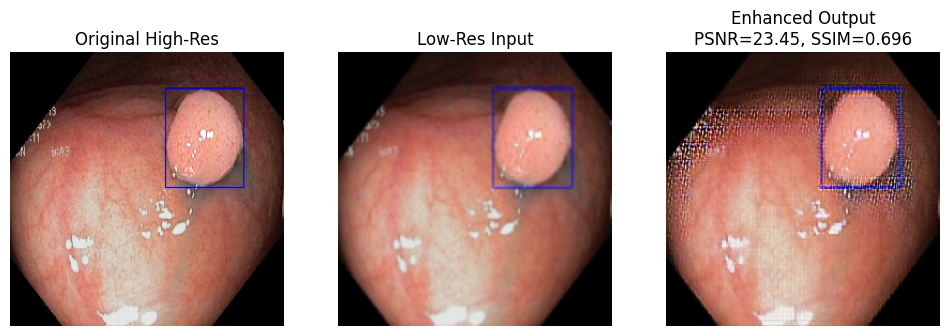

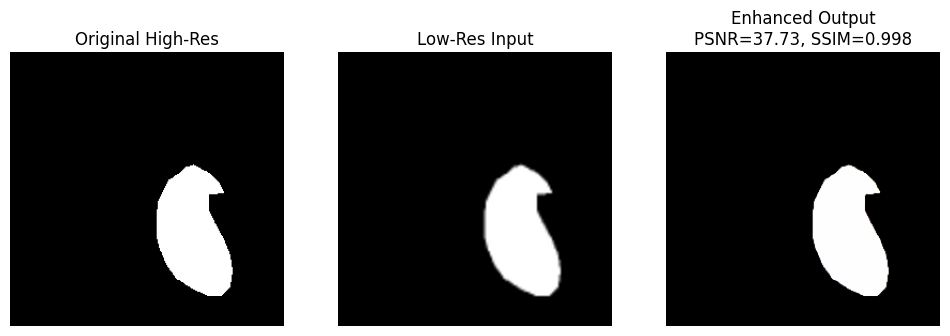

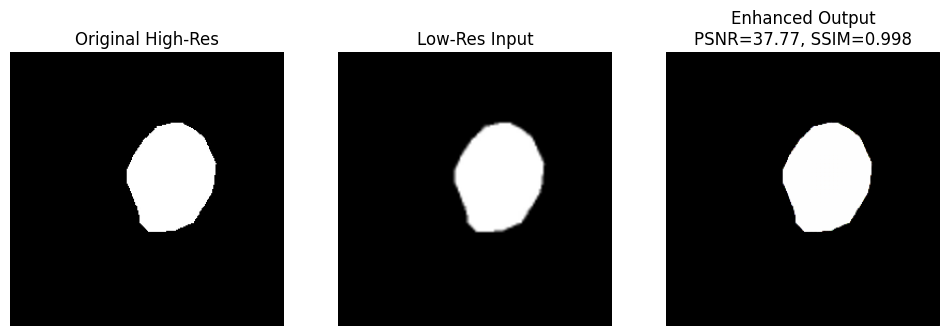

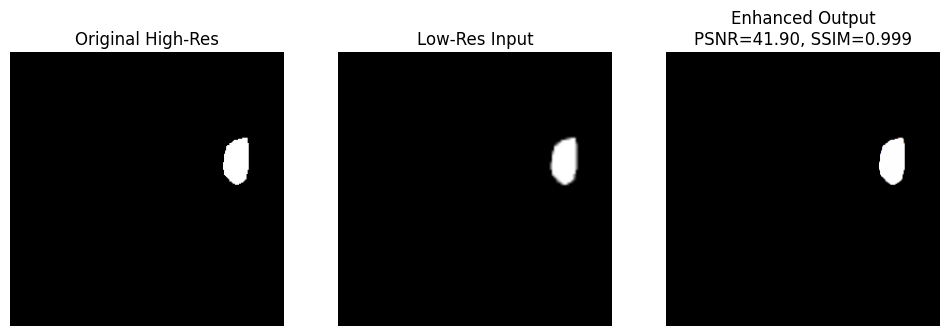

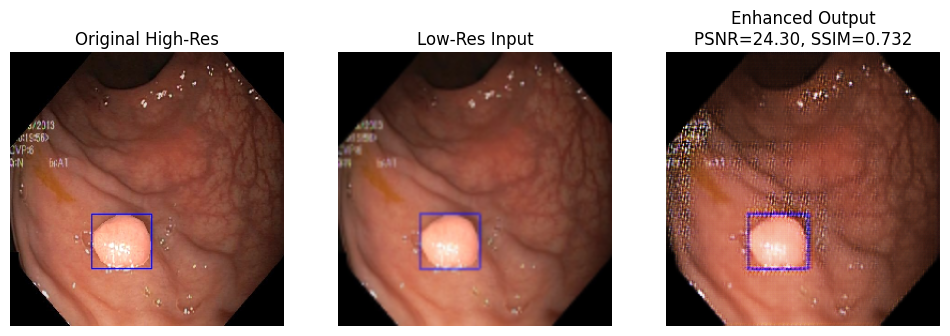

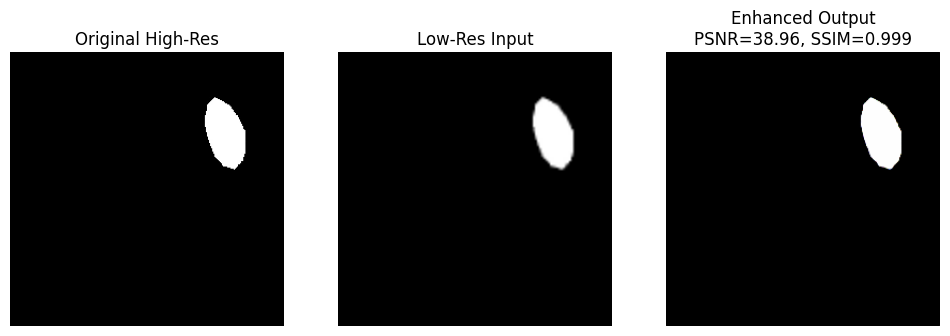

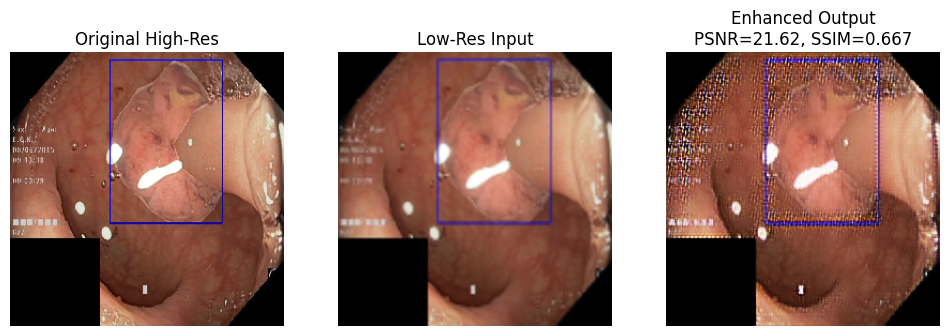

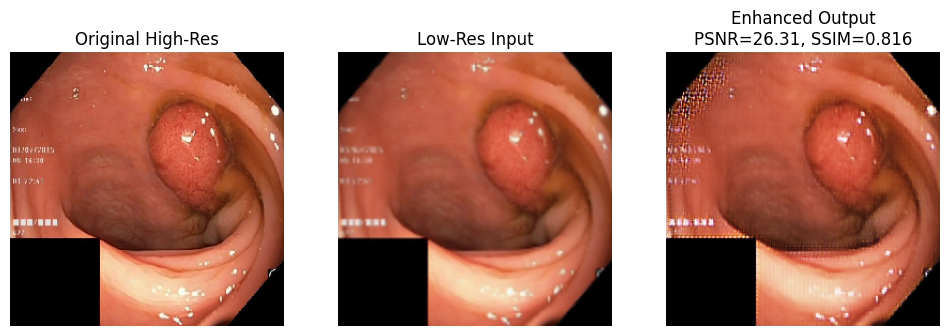

Enhanced images saved at 'enhanced_results' with PSNR/SSIM metrics.


In [15]:
output_dir = "enhanced_results"
os.makedirs(output_dir, exist_ok=True)
metrics = []

num_demo_images = min(train_gen.n, 20)  # first 20 images for demo

for i in range(num_demo_images):
    # Determine batch and index within batch
    batch_idx = i // BATCH_SIZE
    idx_in_batch = i % BATCH_SIZE
    batch = train_gen[batch_idx]

    # Original high-res image (RGB)
    high_res = tf.convert_to_tensor(batch[idx_in_batch], dtype=tf.float32)

    # Low-res version for generator input
    low_res = tf.image.resize(high_res, [IMG_SIZE//2, IMG_SIZE//2])
    low_res = tf.image.resize(low_res, [IMG_SIZE, IMG_SIZE])

    # Enhance using generator
    enhanced = generator(tf.expand_dims(low_res, 0), training=False)[0]
    enhanced_img = tf.clip_by_value(enhanced, 0.0, 1.0)

    # Save enhanced image with RGB preserved
    out_path = os.path.join(output_dir, f"enhanced_{i}.png")
    plt.imsave(out_path, enhanced_img.numpy(), format='png')  # RGB preserved

    # Compute metrics
    psnr, ssim = evaluate_quality(high_res, enhanced_img)
    metrics.append([f"img_{i}", psnr, ssim])

    # Optional: show images in a row
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original High-Res")
    plt.imshow(high_res)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Low-Res Input")
    plt.imshow(low_res)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title(f"Enhanced Output\nPSNR={psnr:.2f}, SSIM={ssim:.3f}")
    plt.imshow(enhanced_img)
    plt.axis('off')

    plt.show()

# Save metrics to CSV
metrics_df = pd.DataFrame(metrics, columns=["Image", "PSNR", "SSIM"])
metrics_df.to_csv(os.path.join(output_dir, "metrics.csv"), index=False)
print(f"Enhanced images saved at '{output_dir}' with PSNR/SSIM metrics.")


In [16]:
# !pip install gradio tensorflow matplotlib pandas kagglehub

# app.py

In [17]:

import gradio as gr
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

IMG_SIZE = 256  # match training

# --- PSNR / SSIM Evaluation ---
def evaluate_quality(true, pred):
    psnr = tf.image.psnr(true, pred, max_val=1.0)
    ssim = tf.image.ssim(true, pred, max_val=1.0)
    return float(tf.reduce_mean(psnr)), float(tf.reduce_mean(ssim))

# --- Prediction Function for UI ---
def enhance_image(uploaded_image):
    try:
        # Uploaded image is already a PIL Image
        img = uploaded_image.convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        high_res = np.array(img) / 255.0

        # Create low-res version
        low_res = tf.image.resize(high_res, [IMG_SIZE//2, IMG_SIZE//2])
        low_res = tf.image.resize(low_res, [IMG_SIZE, IMG_SIZE])

        # Add batch dimension
        input_tensor = tf.expand_dims(low_res, 0)

        # Run generator
        enhanced = generator(input_tensor, training=False)[0]
        enhanced = tf.clip_by_value(enhanced, 0.0, 1.0)

        # Convert to PIL for Gradio display
        high_res_img = Image.fromarray((high_res * 255).astype(np.uint8))
        low_res_img  = Image.fromarray((low_res.numpy() * 255).astype(np.uint8))
        enhanced_img = Image.fromarray((enhanced.numpy() * 255).astype(np.uint8))

        # Compute metrics
        psnr, ssim = evaluate_quality(tf.convert_to_tensor(high_res[None,...]), enhanced[None,...])
        metrics_text = f"PSNR: {psnr:.2f} dB | SSIM: {ssim:.3f}"

        return low_res_img, enhanced_img, high_res_img, metrics_text

    except Exception as e:
        return None, None, None, f"Error: {e}"

# --- Prediction Function for UI ---
def enhance_image(uploaded_image):
    try:
        # --- Convert image to float32 and resize ---
        img = uploaded_image.convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        high_res = np.array(img).astype(np.float32) / 255.0  # ✅ float32

        # Create low-res version
        low_res = tf.image.resize(high_res, [IMG_SIZE//2, IMG_SIZE//2])
        low_res = tf.image.resize(low_res, [IMG_SIZE, IMG_SIZE])
        low_res = tf.cast(low_res, tf.float32)  # ✅ ensure float32

        # Add batch dimension
        input_tensor = tf.expand_dims(low_res, 0)

        # --- Make sure generator model is loaded ---
        # Replace this with your actual trained generator path
        global generator
        if 'generator' not in globals():
            generator = tf.keras.models.load_model("generator_model.h5", compile=False)

        # Run generator
        enhanced = generator(input_tensor, training=False)[0]
        enhanced = tf.clip_by_value(enhanced, 0.0, 1.0)

        # Convert to PIL for Gradio display
        high_res_img = Image.fromarray((high_res * 255).astype(np.uint8))
        low_res_img  = Image.fromarray((low_res.numpy() * 255).astype(np.uint8))
        enhanced_img = Image.fromarray((enhanced.numpy() * 255).astype(np.uint8))

        # Compute metrics (cast to float32 to avoid dtype errors)
        psnr, ssim = evaluate_quality(
            tf.convert_to_tensor(high_res[None,...], dtype=tf.float32),
            tf.convert_to_tensor(enhanced[None,...], dtype=tf.float32)
        )
        metrics_text = f"PSNR: {psnr:.2f} dB | SSIM: {ssim:.3f}"

        return low_res_img, enhanced_img, high_res_img, metrics_text

    except Exception as e:
        return None, None, None, f"Error: {e}"

# MediSharp App

In [18]:
import gradio as gr

# --- Gradio UI ---
with gr.Blocks() as demo:
    gr.Markdown("<h1 style='text-align:center'>MediSharp</h1>")
    gr.Markdown("Upload a CT / Endoscopy image to see Low-Res vs Enhanced result.")

    with gr.Row():
        inp = gr.Image(type="pil", label="Upload Medical Image")  # <-- changed to pil
        btn = gr.Button("Enhance Image ⚡")

    with gr.Row():
        low_res_out = gr.Image(label="Low-Res Input")
        enhanced_out = gr.Image(label="Enhanced Output")
        high_res_out = gr.Image(label="Original Image")

    metrics = gr.Textbox(label="Image Quality Metrics (PSNR / SSIM)", interactive=False)

    # Click event
    btn.click(fn=enhance_image,
              inputs=inp,
              outputs=[low_res_out, enhanced_out, high_res_out, metrics])

# Launch the app
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ec1d09a465434e6434.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:
# import gradio as gr
# import tensorflow as tf
# import numpy as np
# from PIL import Image

# IMG_SIZE = 256  # match training

# # --- PSNR / SSIM Evaluation ---
# def evaluate_quality(true, pred):
#     psnr = tf.image.psnr(true, pred, max_val=1.0)
#     ssim = tf.image.ssim(true, pred, max_val=1.0)
#     return float(tf.reduce_mean(psnr)), float(tf.reduce_mean(ssim))

# # --- Prediction Function for UI ---
# def enhance_image(uploaded_image):
#     try:
#         img = uploaded_image.convert("RGB").resize((IMG_SIZE, IMG_SIZE))
#         high_res = np.array(img).astype(np.float32) / 255.0

#         # Low-res version
#         low_res = tf.image.resize(high_res, [IMG_SIZE//2, IMG_SIZE//2])
#         low_res = tf.image.resize(low_res, [IMG_SIZE, IMG_SIZE])
#         low_res = tf.cast(low_res, tf.float32)

#         input_tensor = tf.expand_dims(low_res, 0)

#         # Load generator if not already loaded
#         global generator
#         if 'generator' not in globals():
#             generator = tf.keras.models.load_model("generator_model.h5", compile=False)

#         enhanced = generator(input_tensor, training=False)[0]
#         enhanced = tf.clip_by_value(enhanced, 0.0, 1.0)

#         # Convert to PIL
#         high_res_img = Image.fromarray((high_res*255).astype(np.uint8))
#         low_res_img = Image.fromarray((low_res.numpy()*255).astype(np.uint8))
#         enhanced_img = Image.fromarray((enhanced.numpy()*255).astype(np.uint8))

#         # Metrics
#         psnr, ssim = evaluate_quality(
#             tf.convert_to_tensor(high_res[None,...], dtype=tf.float32),
#             tf.convert_to_tensor(enhanced[None,...], dtype=tf.float32)
#         )
#         metrics_text = f"PSNR: {psnr:.2f} dB | SSIM: {ssim:.3f}"

#         return low_res_img, enhanced_img, high_res_img, metrics_text

#     except Exception as e:
#         return None, None, None, f"Error: {e}"

# # --- Gradio UI ---
# with gr.Blocks(theme=gr.themes.Soft()) as demo:
#     gr.Markdown("🧠 Super-Resolution Enhancement")
#     gr.Markdown("Upload a medical image to see low-res, enhanced, and original side by side.")

#     with gr.Row():
#       with gr.Column(scale=1):
#         inp = gr.Image(type="pil", label="Upload Image")  # Removed 'tool'
#         btn = gr.Button("Enhance ⚡", variant="primary")
#         metrics = gr.Textbox(label="Image Quality Metrics (PSNR / SSIM)", interactive=False)

#         with gr.Column(scale=2):
#             with gr.Tab("Low-Res / Input"):
#                 low_res_out = gr.Image(label="Low-Res Input")
#             with gr.Tab("Enhanced Output"):
#                 enhanced_out = gr.Image(label="Enhanced Output")
#             with gr.Tab("Original Image"):
#                 high_res_out = gr.Image(label="Original High-Res")

#     btn.click(
#         fn=enhance_image,
#         inputs=inp,
#         outputs=[low_res_out, enhanced_out, high_res_out, metrics]
#     )

# demo.launch(share=True)


